In [1]:
# install.packages("glmnet")
# install.packages('gridExtra')
# install.packages("randomForest")

library(glmnet)
library(randomForest)
library(ggplot2)
library(grid)
library(gridExtra)
library(viridis)
library(dplyr)
library(tidyverse)

set.seed(3)

Warning message:
“package ‘glmnet’ was built under R version 3.6.2”
Loading required package: Matrix

Warning message:
“package ‘Matrix’ was built under R version 3.6.2”
Loaded glmnet 4.1-2

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

Warning message:
“package ‘ggplot2’ was built under R version 3.6.2”

Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin



Attaching package: ‘gridExtra’


The following object is masked from ‘package:randomForest’:

    combine


Warning message:
“package ‘viridis’ was built under R version 3.6.2”
Loading required package: viridisLite

Warning message:
“package ‘viridisLite’ was built under R version 3.6.2”
Warning message:
“package ‘dplyr’ was built under R version 3.6.2”

Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following object is masked from ‘package:randomForest’:

    combine


The following objects are

In [2]:
data <- read_csv("https://raw.githubusercontent.com/tmvien/pneumonia/master/train.csv")
data <- data[-1,]
rownames(data) <- 1:nrow(data)

Rows: 5232 Columns: 785

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): 784
dbl (784): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Warning message:
“Setting row names on a tibble is deprecated.”


In [3]:
# confirm pixel range is 0-255
range(data[,-ncol(data)])

[1]   0 255

In [4]:
names(data)[ncol(data)] <- c("class")
# recode target as 0 and 1
data["class"] <- ifelse(data["class"] == "NORMAL", 0, 1)

In [5]:
sum(data["class"] == 1)/nrow(data)
sum(data["class"] == 0)/nrow(data)

[1] 0.7423055

[1] 0.2576945

In [6]:
# normalize the image pixels by diving by 255
data[,-ncol(data)] = data[,-ncol(data)]/255

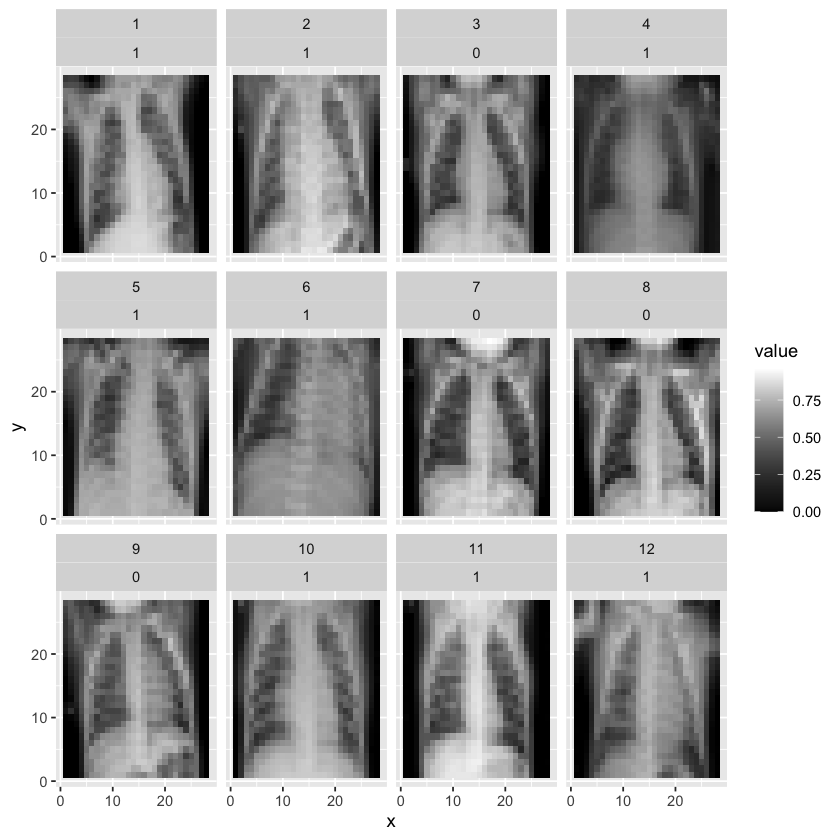

In [7]:
samp.ind    <- sample(dim(data)[1], dim(data)[1])
data        <- data[samp.ind,]
data %>%
  mutate(instance = row_number()) %>%  
  gather(pixel, value, -class, -instance) %>%  
  tidyr::extract(pixel, "pixel", "(\\d+)", convert = TRUE) %>%  
  mutate(x = pixel %% 28 + 1, y = 28 - pixel %/% 28) %>%
  filter(instance <= 12) %>%  
  ggplot(aes(x, y, fill = value)) +  geom_tile() +  
  scale_fill_gradient(low="black", high="white") + 
  facet_wrap(~ instance + class)

In [7]:
# shuffle data
samp.ind    <- sample(dim(data)[1], dim(data)[1])
X           <- as.matrix(data[samp.ind, -ncol(data)])
y           <- data[samp.ind,]$class

# remove data
rm(data)

n                  <- dim(X)[1]
p                  <- dim(X)[2]
train.rate         <- 0.9
iterations         <- 50
K                  <- 10

# train and val auc matrices
train.auc            <-  matrix(0, nrow = iterations, ncol = 4)
colnames(train.auc)  <-  c("LRidge", "LLasso", "LElastic", "RF")

val.auc              <-  matrix(0, nrow = iterations, ncol = 4)
colnames(val.auc)    <-  c("LRidge", "LLasso", "LElastic", "RF")

# ridge, lasso, elasticNet coefficient matrices
rid.coef             <-  matrix(0, nrow = iterations, ncol = p+1)
lasso.coef           <-  matrix(0, nrow = iterations, ncol = p+1)
el.coef              <-  matrix(0, nrow = iterations, ncol = p+1)
# RF
rf.importance        <-  matrix(0, nrow = iterations, ncol = p)

# time for cv and model fit
time.cv              <-  matrix(0, nrow = iterations, ncol = 3)
colnames(time.cv)    <-  c("LRidge", "LLasso", "LElastic")
time.fit             <-  matrix(0, nrow = iterations, ncol = 4)
colnames(time.fit)   <-  c("LRidge", "LLasso", "LElastic", "RF")

In [8]:
# function for auc 
auc <- function(TPR, FPR){
    # sort inputs, best scores first 
    TPR     <-  sort(TPR)
    FPR     <-  sort(FPR)
    dFPR    <-  c(diff(FPR), 0)
    dTPR    <-  c(diff(TPR), 0)
    sum(TPR * dFPR) + sum(dTPR * dFPR)/2
}

# sensitivity function for auc
sens.cal <- function(y, prob) {
    # vector of thresholds
    thresh        <-  seq(0, 1, 0.01)

    # empty matrices
    sens  <-  matrix(0, nrow = length(thresh), ncol = 1)
    ind = 1
    for (i in thresh) {
        y.hat         <-    ifelse(prob > i, 1, 0)
        # FP, TP, FPR, TPR calculation
        TP            <-    sum(y.hat[y==1] == 1) # true positives = positives in the data that were predicted as positive
        P             <-    sum(y==1) # total positives in the data
        TPR           <-    TP/P # true positive rate = 1 - type 2 error = sensitivity = recall
        sens[ind,]    <-    TPR 
        ind           <-    ind + 1
    }
    return(sens)
}

# false positive rate functions for auc
fpr.cal <- function(y, prob) {
    # vector of thresholds
    thresh        <-  seq(0, 1, 0.01)

    # empty matrices
    fpr   <-  matrix(0, nrow = length(thresh), ncol = 1)
    ind = 1
    for (i in thresh) {
        y.hat         <-    ifelse(prob > i, 1, 0)
        # FP, TP, FPR, TPR calculation
        FP            <-    sum(y[y.hat==1] == 0) # false positives = negatives in the data that were predicted as positive
        N             <-    sum(y==0) # total negatives in the data
        FPR           <-    FP/N # false positive rate = type 1 error = 1 - specificity
        fpr[ind,]     <-    FPR
        ind           <-    ind + 1
    }
  return(fpr)
}

In [9]:
for(m in 1:iterations) {
    #print(paste0("Iteration = ", m))
    cat(sprintf("iteration = %3.f \n", m))
    flush.console()

    train            <-  sample(n, n*train.rate)

    # decide weights for imbalanced data
    nP               <-  sum(y[train]) 
    nN               <-  length(train) - nP 
    w                <-  rep(1, length(train))
    w[y[train] == 1] <-  nN/nP
    # weight for rf
    w.rf             <-  c("0" = 1, "1" = nN/nP)

    ############## ridge 
    # begin cross-validation
    start.time   <- proc.time()
    cv.rid       <- cv.glmnet(X[train,], y[train],
                              alpha = 0,
                              family = "binomial",
                              weights = w,
                              nfolds = K,
                              type.measure="auc")
    end.time      <-  proc.time() - start.time
    time.cv[m,1]  <-  end.time["elapsed"]
    # begin model fit
    start.time    <-  proc.time()
    rid.fit       <-  glmnet(X[train,], y[train],
                             alpha = 0,
                             family = "binomial",
                             lambda = cv.rid$lambda.min,
                             weights = w,
                             standardize = F)
    end.time      <-  proc.time() - start.time
    time.fit[m,1] <-  end.time["elapsed"]
    #### calculate auc for train and valid
    # feature coefficients
    rid.coef[m,1]   <-     rid.fit$a0
    rid.coef[m,-1]  <-     as.vector(rid.fit$beta)
    # probability predictions
    prob.train.rid  <-     exp( X[train,]  %*% as.vector(rid.fit$beta) +  rid.fit$a0  )/(1 + exp(X[train,]  %*% as.vector(rid.fit$beta) +  rid.fit$a0  ))
    prob.val.rid    <-     exp( X[-train,] %*% as.vector(rid.fit$beta) +  rid.fit$a0  )/(1 + exp(X[-train,] %*% as.vector(rid.fit$beta) +  rid.fit$a0  ))
    # auc train and valid
    auc.train.rid             <-    auc( sens.cal(y[train],  prob.train.rid), fpr.cal(y[train], prob.train.rid ))
    auc.valid.rid             <-    auc( sens.cal(y[-train], prob.val.rid  ), fpr.cal(y[-train], prob.val.rid  ))
    train.auc[m,1]            <-    auc.train.rid
    val.auc[m,1]              <-    auc.valid.rid

    ############ lasso regression
    # begin cross validate
    start.time  <-  proc.time()
    cv.lasso    <-  cv.glmnet(X[train,], y[train],
                              alpha = 1,
                              family = "binomial",
                              weights = w,
                              nfolds = K,
                              type.measure="auc")
    end.time     <-  proc.time() - start.time
    time.cv[m,2] <-  end.time["elapsed"]
    # begin model fit
    start.time   <- proc.time()
    lasso.fit    <- glmnet(X[train,], y[train],
                           alpha = 1,
                           family = "binomial",
                           lambda = cv.lasso$lambda.min,
                           weights = w,
                           standardize = F)
    end.time       <-  proc.time() - start.time
    time.fit[m,2]  <-  end.time["elapsed"]
    #### calculate auc for train and valid
    # feature coefficients
    lasso.coef[m,1]   <-     lasso.fit$a0
    lasso.coef[m,-1]  <-     as.vector(lasso.fit$beta)
    # probability predictions
    prob.train.lasso  <-     exp( X[train,]  %*% as.vector(lasso.fit$beta) +  lasso.fit$a0  )/(1 + exp(X[train,]  %*% as.vector(lasso.fit$beta) +  lasso.fit$a0  ))
    prob.val.lasso    <-     exp( X[-train,] %*% as.vector(lasso.fit$beta) +  lasso.fit$a0  )/(1 + exp(X[-train,] %*% as.vector(lasso.fit$beta) +  lasso.fit$a0  ))
    # auc train and valid
    auc.train.lasso          <-    auc( sens.cal(y[train],  prob.train.lasso), fpr.cal(y[train], prob.train.lasso ))
    auc.valid.lasso          <-    auc( sens.cal(y[-train], prob.val.lasso  ), fpr.cal(y[-train], prob.val.lasso  ))
    train.auc[m,2]           <-    auc.train.lasso
    val.auc[m,2]             <-    auc.valid.lasso

    ############# elastic net
    # begin cross-validation
    start.time    <-   proc.time()
    cv.el         <-   cv.glmnet(X[train,], y[train],
                                 alpha = 0.5, 
                                 family = "binomial",
                                 weights = w,
                                 nfolds = K,
                                 type.measure="auc")
    end.time      <-   proc.time() - start.time
    time.cv[m,3]  <-   end.time["elapsed"]
    # begin model fit
    start.time    <-   proc.time()
    el.fit        <-   glmnet(X[train,], y[train], 
                              alpha = 0.5, 
                              family = "binomial",
                              lambda = cv.el$lambda.min,
                              weights = w,
                              standardize = F)
    end.time      <-   proc.time() - start.time
    time.fit[m,3] <-   end.time["elapsed"]
    #### calculate auc for train and valid
    # feature coefficients
    el.coef[m,1]   <-     el.fit$a0
    el.coef[m,-1]  <-     as.vector(el.fit$beta)
    # probability predictions
    prob.train.el  <-     exp( X[train,]  %*% as.vector(el.fit$beta) +  el.fit$a0  )/(1 + exp(X[train,]  %*% as.vector(el.fit$beta) +  el.fit$a0  ))
    prob.val.el    <-     exp( X[-train,] %*% as.vector(el.fit$beta) +  el.fit$a0  )/(1 + exp(X[-train,] %*% as.vector(el.fit$beta) +  el.fit$a0  ))
    # auc train and valid
    auc.train.el          <-    auc( sens.cal(y[train],  prob.train.el), fpr.cal(y[train], prob.train.el ))
    auc.valid.el          <-    auc( sens.cal(y[-train], prob.val.el  ), fpr.cal(y[-train], prob.val.el  ))
    train.auc[m,3]        <-    auc.train.el
    val.auc[m,3]          <-    auc.valid.el

    ############### random forest 
    # begin model fit
    start.time     <-  proc.time()
    rf             <-  randomForest(x=X[train,], y=as.factor(y[train]),
                                    mtry = sqrt(p),
                                    classwt = w.rf,
                                    importance = T
                                  )
    end.time       <-  proc.time() - start.time
    time.fit[m,4]  <-  end.time["elapsed"]
    #### calculate auc for train and valid
    # feature importance
    rf.importance[m,]  <- rf$importance[,1] 
    # probability predictions
    prob.train.rf      <-  predict(rf, newdata = X[train,],  type = "prob")[,2]
    prob.val.rf        <-  predict(rf, newdata = X[-train,], type = "prob")[,2]
    # auc train and valid
    auc.train.rf          <-    auc( sens.cal(y[train],  prob.train.rf), fpr.cal(y[train], prob.train.rf ))
    auc.valid.rf          <-    auc( sens.cal(y[-train], prob.val.rf  ), fpr.cal(y[-train], prob.val.rf  ))
    train.auc[m,4]        <-    auc.train.rf
    val.auc[m,4]          <-    auc.valid.rf
    }


iteration =   1 
iteration =   2 
iteration =   3 
iteration =   4 
iteration =   5 
iteration =   6 
iteration =   7 
iteration =   8 
iteration =   9 
iteration =  10 
iteration =  11 
iteration =  12 
iteration =  13 
iteration =  14 
iteration =  15 
iteration =  16 
iteration =  17 
iteration =  18 
iteration =  19 
iteration =  20 
iteration =  21 
iteration =  22 
iteration =  23 
iteration =  24 
iteration =  25 
iteration =  26 
iteration =  27 
iteration =  28 
iteration =  29 
iteration =  30 
iteration =  31 
iteration =  32 
iteration =  33 
iteration =  34 
iteration =  35 
iteration =  36 
iteration =  37 
iteration =  38 
iteration =  39 
iteration =  40 
iteration =  41 
iteration =  42 
iteration =  43 
iteration =  44 
iteration =  45 
iteration =  46 
iteration =  47 
iteration =  48 
iteration =  49 
iteration =  50 


jpeg 
   3

png 
  2

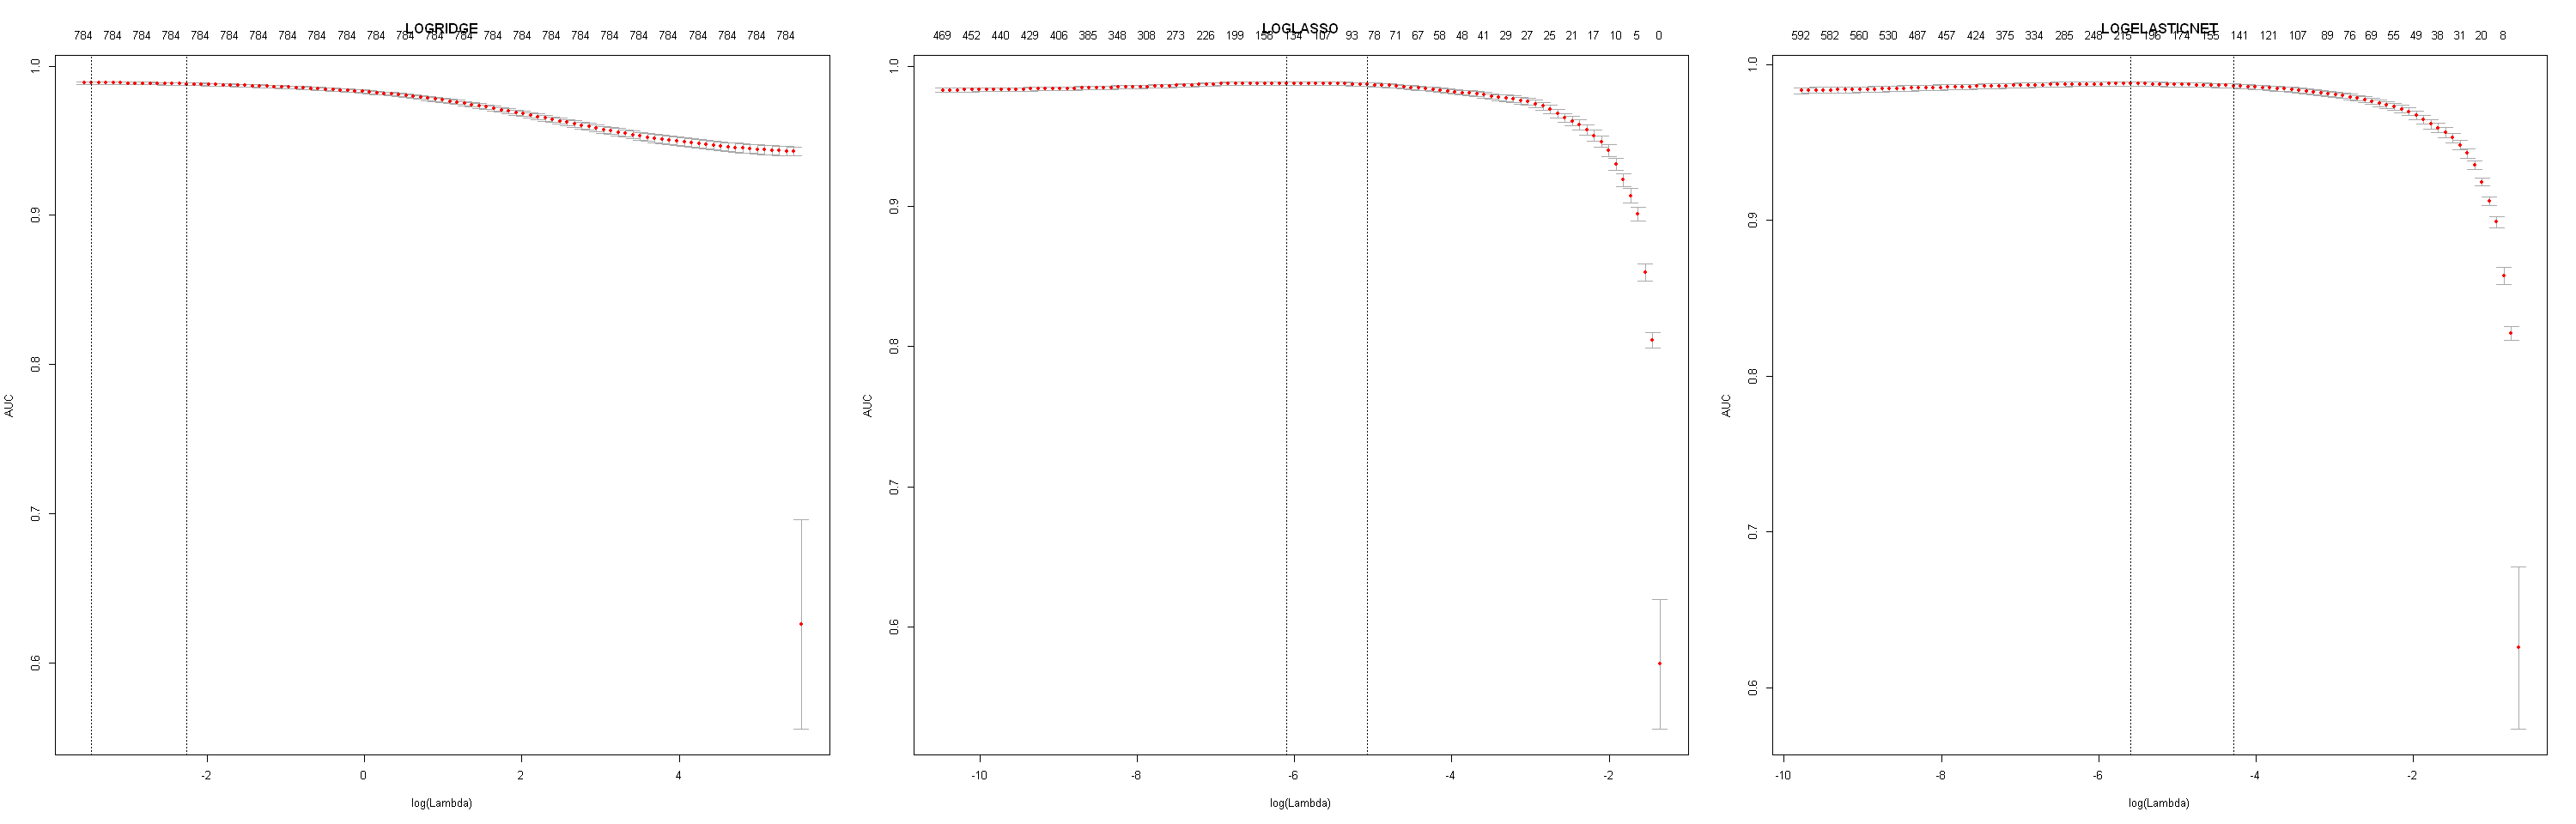

In [11]:
par(mfrow=c(1,3))
options(repr.plot.width=25, repr.plot.height=8)
plot(cv.rid, main="LOGRIDGE")
plot(cv.lasso, main='LOGLASSO' )
plot(cv.el, main='LOGELASTICNET')
dev.copy(jpeg, filename="cv_curve.jpg");
dev.off();

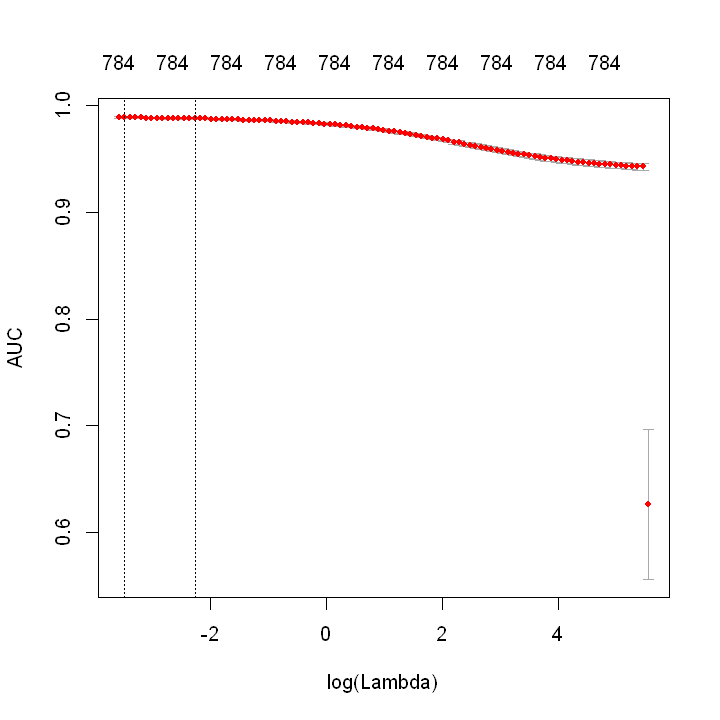

In [40]:
options(repr.plot.width=6, repr.plot.height=6)
plot(cv.rid, main="")

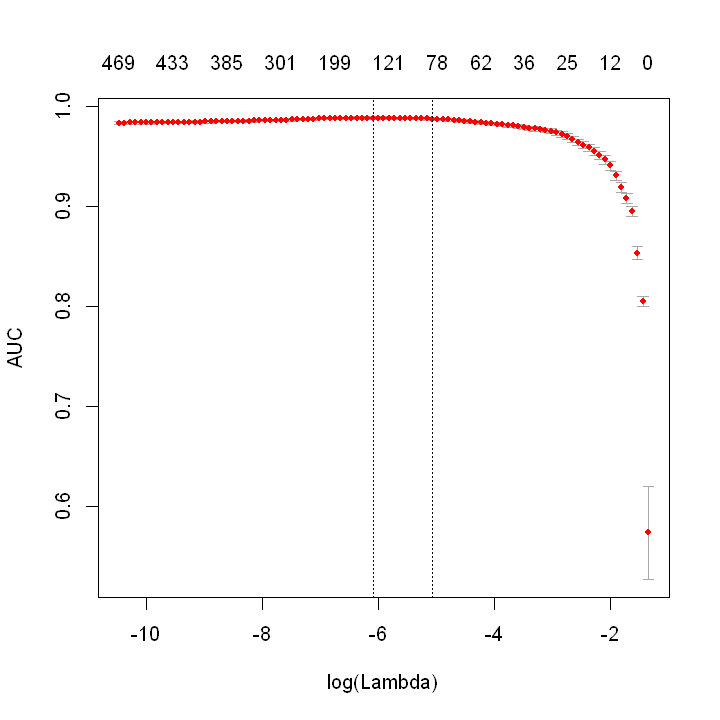

In [41]:
plot(cv.lasso, main="")

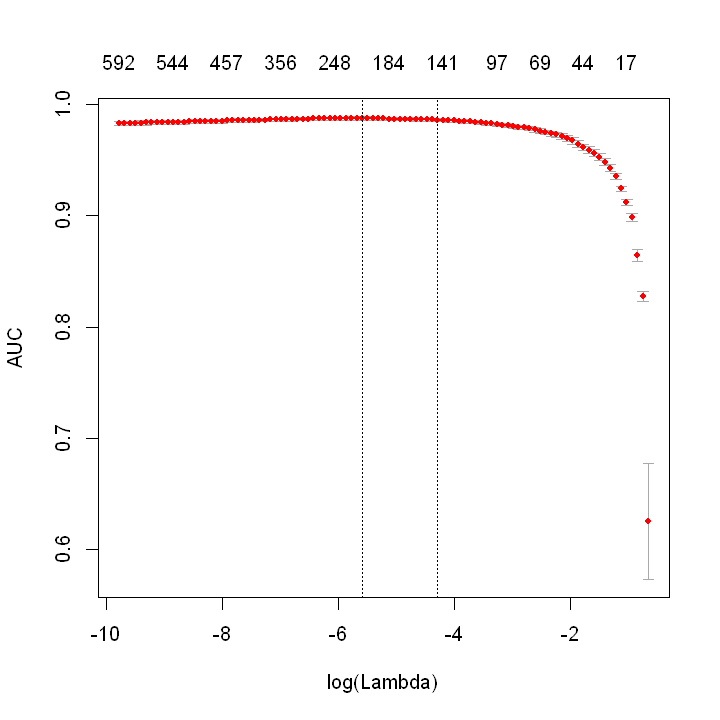

In [42]:
plot(cv.el, main="")

In [12]:
# colnames(rid.coef)      <- c("intercept", paste0("X.", 1:784))
# colnames(lasso.coef)    <- c("intercept", paste0("X.", 1:784))
# colnames(el.coef)       <- c("intercept", paste0("X.", 1:784))
# colnames(rf.importance) <- c(paste0("X.", 1:784))

# write.csv(rid.coef, file="rid_coef.csv", row.names=F)
# write.csv(lasso.coef, file="lasso_coef.csv", row.names=F)
# write.csv(el.coef, file="el_coef.csv", row.names=F)
# write.csv(rf.importance, file="rf_importance.csv", row.names=F)

# # train.auc <- data.frame(train.auc)
# write.csv(train.auc, file="train_auc.csv", row.names = F)
# # val.auc <- data.frame(val.auc)
# write.csv(val.auc, file="val_auc.csv", row.names = F)

# write.csv(time.cv, file="timecv.csv", row.names=F)
# write.csv(time.fit, file="timefit.csv", row.names=F)


In [1]:
train.auc <- read.csv("train_auc.csv")
val.auc   <- read.csv("val_auc.csv")

time.cv   <- read.csv("timecv.csv")
time.fit  <- read.csv("timefit.csv")

In [4]:
apply(val.auc, 2, median)

LRidge    LLasso  LElastic        RF 
0.9805153 0.9834749 0.9845721 0.9754870

In [5]:
apply(val.auc, 2, mean)

LRidge    LLasso  LElastic        RF 
0.9794407 0.9826509 0.9836216 0.9770583

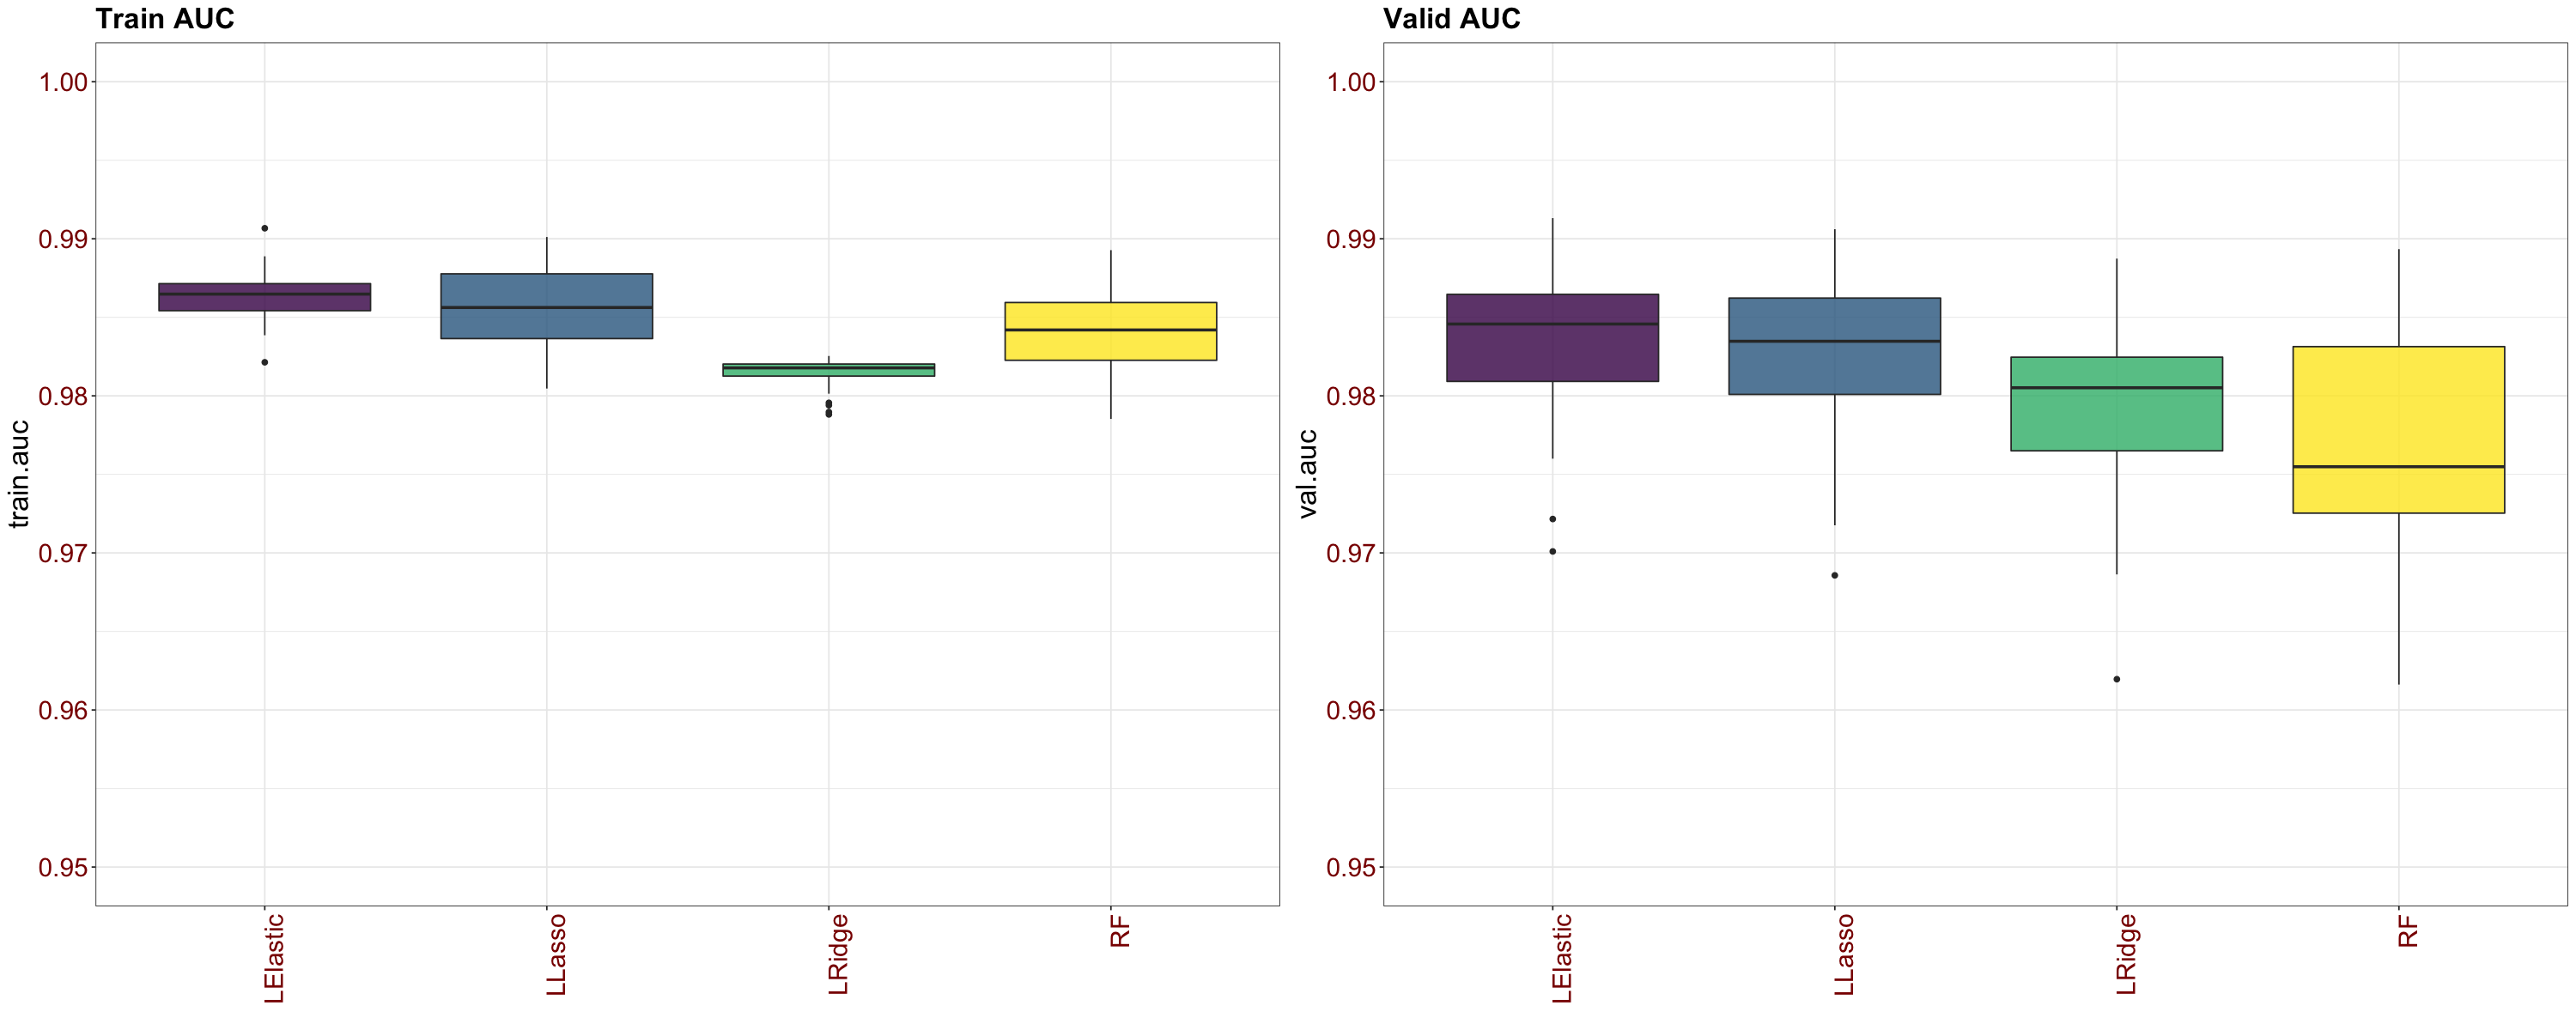

In [28]:
options(repr.plot.width=25, repr.plot.height=10)

limits <- c(0.95, 1)
breaks <- seq(limits[1], limits[2], by=.01)

g1 <- train.auc %>%
  gather(key=models, value=train.auc) %>%
  ggplot(aes(x=models, y=train.auc, fill=models)) +
    geom_boxplot() +
    scale_y_continuous(limits=limits, breaks=breaks) + 
    scale_fill_viridis(discrete = TRUE, alpha=0.8, option="D") +
    scale_color_viridis(discrete = TRUE) +
    theme_bw() +
    theme(
      legend.position="none",
      plot.title = element_text(size=20, face = "bold"),
      axis.text.x = element_text(angle = 90, hjust = 1, size=18,color="darkred"),
      axis.text.y = element_text(hjust = 1, size=18,color="darkred"),
      axis.title.y = element_text(size = rel(1.8), angle = 90)
    ) +
    ggtitle("Train AUC") +
    xlab("")

g2 <- val.auc %>%
  gather(key=models, value=val.auc) %>%
  ggplot(aes(x=models, y=val.auc, fill=models)) +
    geom_boxplot() +
    scale_y_continuous(limits=limits, breaks=breaks) + 
    scale_fill_viridis(discrete = TRUE, alpha=0.8, option="D") +
    scale_color_viridis(discrete = TRUE) +
    theme_bw() +
    theme(
      legend.position="none",
      plot.title = element_text(size=20, , face = "bold"),
      axis.text.x = element_text(angle = 90, hjust = 1, size=18,color="darkred"),
      axis.text.y = element_text(hjust = 1, size=18,color="darkred"),
      axis.title.y = element_text(size = rel(1.8), angle = 90)
    ) +
    ggtitle("Valid AUC") +
    xlab("")

grid.arrange(g1, g2, ncol=2)

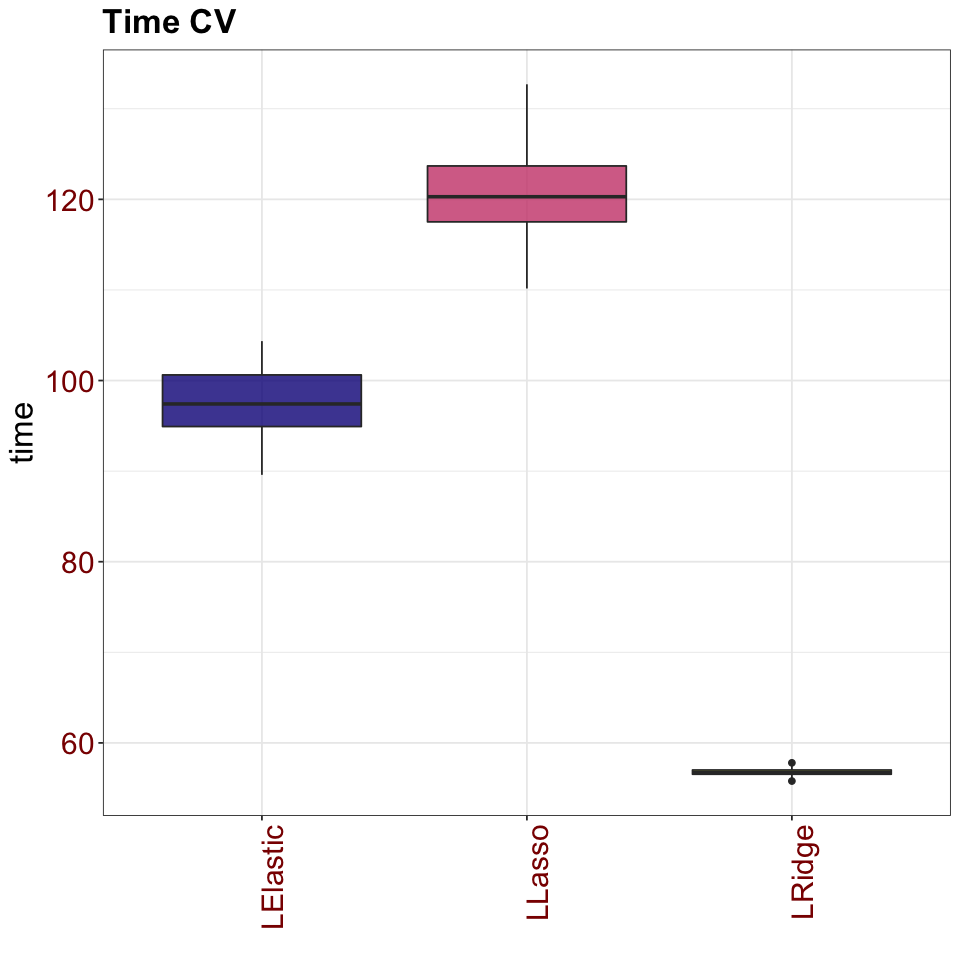

In [3]:
options(repr.plot.width=8, repr.plot.height=8)
time.cv <- data.frame(time.cv)
time.cv %>%
  gather(key=models, value=time) %>%
  ggplot(aes(x=models, y=time, fill=models)) +
    geom_boxplot() +
    #scale_y_continuous(limits=limits, breaks=breaks) + 
    scale_fill_viridis(discrete = TRUE, alpha=0.8, option="C") +
    scale_color_viridis(discrete = TRUE) +
    theme_bw() +
    theme(
      legend.position="none",
      plot.title = element_text(size=20, face = "bold"),
      axis.text.x = element_text(angle = 90, hjust = 1, size=18,color="darkred"),
      axis.text.y = element_text(hjust = 1, size=18,color="darkred"),
      axis.title.y = element_text(size = rel(1.8), angle = 90)
    ) +
    ggtitle("Time CV") +
    xlab("")

In [2]:
apply(time.cv, 2, mean)

LRidge   LLasso LElastic 
 56.7548 120.3480  97.6974

### PLS DISREGARD THE CODE BELOW. WE WILL NOT PERFORM BOOTSTRAP FOR SD OF COEFFICIENTS

In [ ]:
# perform 100 boostrapping samples to find sd of estimated coefficients
# p                <-     dim(X)[2]
# n                <-     dim(X)[1]
# bootstrapSamples <-     100
# beta.rf.bs       <-     matrix(0, nrow = bootstrapSamples, ncol=p)    
# beta.ls.bs       <-     matrix(0, nrow = bootstrapSamples, ncol=p)         
# beta.el.bs       <-     matrix(0, nrow = bootstrapSamples, ncol=p)         
# beta.rd.bs       <-     matrix(0, nrow = bootstrapSamples, ncol=p)         

# for (m in 1:bootstrapSamples){
#     bs_indexes       <-     sample(n, replace=T)
#     # decide weights for imbalanced data
#     nP               <-     sum(y[bs_indexes]) 
#     nN               <-     length(y[bs_indexes]) - nP 
#     w                <-     rep(1, length(y[bs_indexes]))
#     w[y[train] == 1] <-     nN/nP
#     # weight for rf
#     w.rf             <-     c("0" = 1, "1" = nN/nP)

#     ############ridge
#     a                <-     0 # ridge
#     rd.cv.fit        <-     cv.glmnet(X[bs_indexes,], y[bs_indexes], alpha = a, nfolds = K,  weights = w, family="binomial", type.measure="auc")
#     rd.fit           <-     glmnet(X[bs_indexes,], y[bs_indexes], alpha = a, lambda = rd.cv.fit$lambda.min, family="binomial", weights = w, standardize = F)  
#     beta.rd.bs[m,]   <-     as.vector(rd.fit$beta)


#     ##########lasso
#     a                <-     1 # lasso
#     ls.cv.fit        <-     cv.glmnet(X[bs_indexes,], y[bs_indexes], alpha = a, nfolds = K,  weights = w, family="binomial", type.measure="auc")
#     ls.fit           <-     glmnet(X[bs_indexes,], y[bs_indexes], alpha = a, lambda = ls.cv.fit$lambda.min, family="binomial", weights = w, standardize = F)
#     beta.ls.bs[m,]   <-     as.vector(ls.fit$beta)

#     ############el
#     a                <-     0.5 # elastic-net
#     el.cv.fit        <-     cv.glmnet(X[bs_indexes,], y[bs_indexes], alpha = a, nfolds = K,  weights = w, family="binomial", type.measure="auc")
#     el.fit           <-     glmnet(X[bs_indexes,], y[bs_indexes], alpha = a, lambda = el.cv.fit$lambda.min, family="binomial", weights = w, standardize = F)
#     beta.el.bs[m,]   <-     as.vector(el.fit$beta)

#     #############rf
#     rf               =     randomForest(x=X[bs_indexes,], y=as.factor(y[bs_indexes]), mtry = sqrt(p),  classwt = w.rf, importance = TRUE)
#     beta.rf.bs[m,]   =     as.vector(rf$importance[,1])
#     cat(sprintf("Bootstrap Sample %3.f \n", m))
#     flush.console()
# }

# colnames(beta.rf.bs) <- colnames(X)
# colnames(beta.ls.bs) <- colnames(X)
# colnames(beta.el.bs) <- colnames(X)
# colnames(beta.rd.bs) <- colnames(X)


# write.csv(beta.ls.bs, file ="beta_ls_bs.csv")
# write.csv(beta.el.bs, file ="beta_el_bs.csv")
# write.csv(beta.rd.bs, file ="beta_rd_bs.csv")
# write.csv(beta.rf.bs, file ="beta_rf_bs.csv")

# beta.ls.bs <- read.csv("beta_ls_bs.csv")
# beta.el.bs <- read.csv("beta_el_bs.csv")
# beta.rd.bs <- read.csv("beta_rd_bs.csv")
# beta.rf.bs <- read.csv("beta_rf_bs.csv")

# ls.bs.sd <- apply(beta.ls.bs, 2, sd)
# el.bs.sd <- apply(beta.el.bs, 2, sd)
# rd.bs.sd <- apply(beta.rd.bs, 2, sd)
# rf.bs.sd <- apply(beta.rf.bs, 2, sd)

## FIT THE WHOLE DATASET FOR VARIABLES IMPORTANCE GRAPH

In [46]:
# decide weights again for imbalanced data
nP              <-      sum(y)
nN              <-      length(y) - nP
w               <-      rep(1, length(y))
w[y == 1]       <-      nN / nP
# weight for rf
w.rf            <-      c("0" = 1, "1" = nN/nP)

# fit ridge to the whole data
a=0 # ridge
start.time       <-     proc.time()
cv.fit           <-     cv.glmnet(X, y, alpha = a, nfolds = K,  weights = w, family="binomial", type.measure="auc")
rd.fit           <-     glmnet(X, y, alpha = a, lambda = cv.fit$lambda.min, family="binomial", weights = w, standardize = F)
end.time         <-     proc.time() - start.time
time.rd          <-     end.time['elapsed']
betaS.rd         <-     data.frame(colnames(X), as.vector(rd.fit$beta))
colnames(betaS.rd)     <-     c( "features", "coefficients")

# fit lasso to the whole data
a=1 # lasso
start.time       <-     proc.time()
cv.fit           <-     cv.glmnet(X, y, alpha = a, nfolds = K,  weights = w, family="binomial", type.measure="auc")
ls.fit           <-     glmnet(X, y, alpha = a, lambda = cv.fit$lambda.min, family="binomial", weights = w, standardize = F)
end.time         <-     proc.time() - start.time
time.ls          <-     end.time['elapsed'] 
betaS.ls         <-     data.frame(colnames(X), as.vector(ls.fit$beta))
colnames(betaS.ls)     <-     c( "features", "coefficients")

# fit en to the whole data
a=0.5 # elastic-net
start.time       <-     proc.time()
cv.fit           <-     cv.glmnet(X, y, alpha = a, nfolds = K,  weights = w, family="binomial", type.measure="auc")
el.fit           <-     glmnet(X, y, alpha = a, lambda = cv.fit$lambda.min, family="binomial", weights = w, standardize = F)
end.time         <-     proc.time() - start.time
time.el          <-     end.time['elapsed']
betaS.el         <-     data.frame(colnames(X), as.vector(el.fit$beta))
colnames(betaS.el)     <-     c( "features", "coefficients")

# fit rf to the whole data
start.time       <-    proc.time()
rf               <-     randomForest(X, y=as.factor(y), mtry = sqrt(p), classwt = w.rf, importance = TRUE)
end.time         <-    proc.time() - start.time
time.rf          <-    end.time['elapsed']
betaS.rf         <-    data.frame(colnames(X), as.vector(rf$importance[,1]))
colnames(betaS.rf)     <-     c( "features", "coefficients")


In [23]:
time.rd
time.ls
time.el
time.rf

elapsed 
  60.31

elapsed 
 147.52

elapsed 
 114.37

elapsed 
  268.5

In [ ]:
# write.csv(betaS.rd, file="betaS_rd.csv", row.names=F)
# write.csv(betaS.ls, file="betaS_ls.csv", row.names=F)
# write.csv(betaS.el, file="betaS_el.csv", row.names=F)
# write.csv(betaS.rf, file="betaS_rf.csv", row.names=F)

In [1]:
betaS.rd <- read.csv("betaS_rd.csv")
betaS.ls <- read.csv("betaS_ls.csv")
betaS.el <- read.csv("betaS_el.csv")
betaS.rf <- read.csv("betaS_rf.csv")

In [4]:
length(which(betaS.ls$coefficients != 0))

[1] 60

In [5]:
length(which(betaS.el$coefficients != 0))

[1] 226

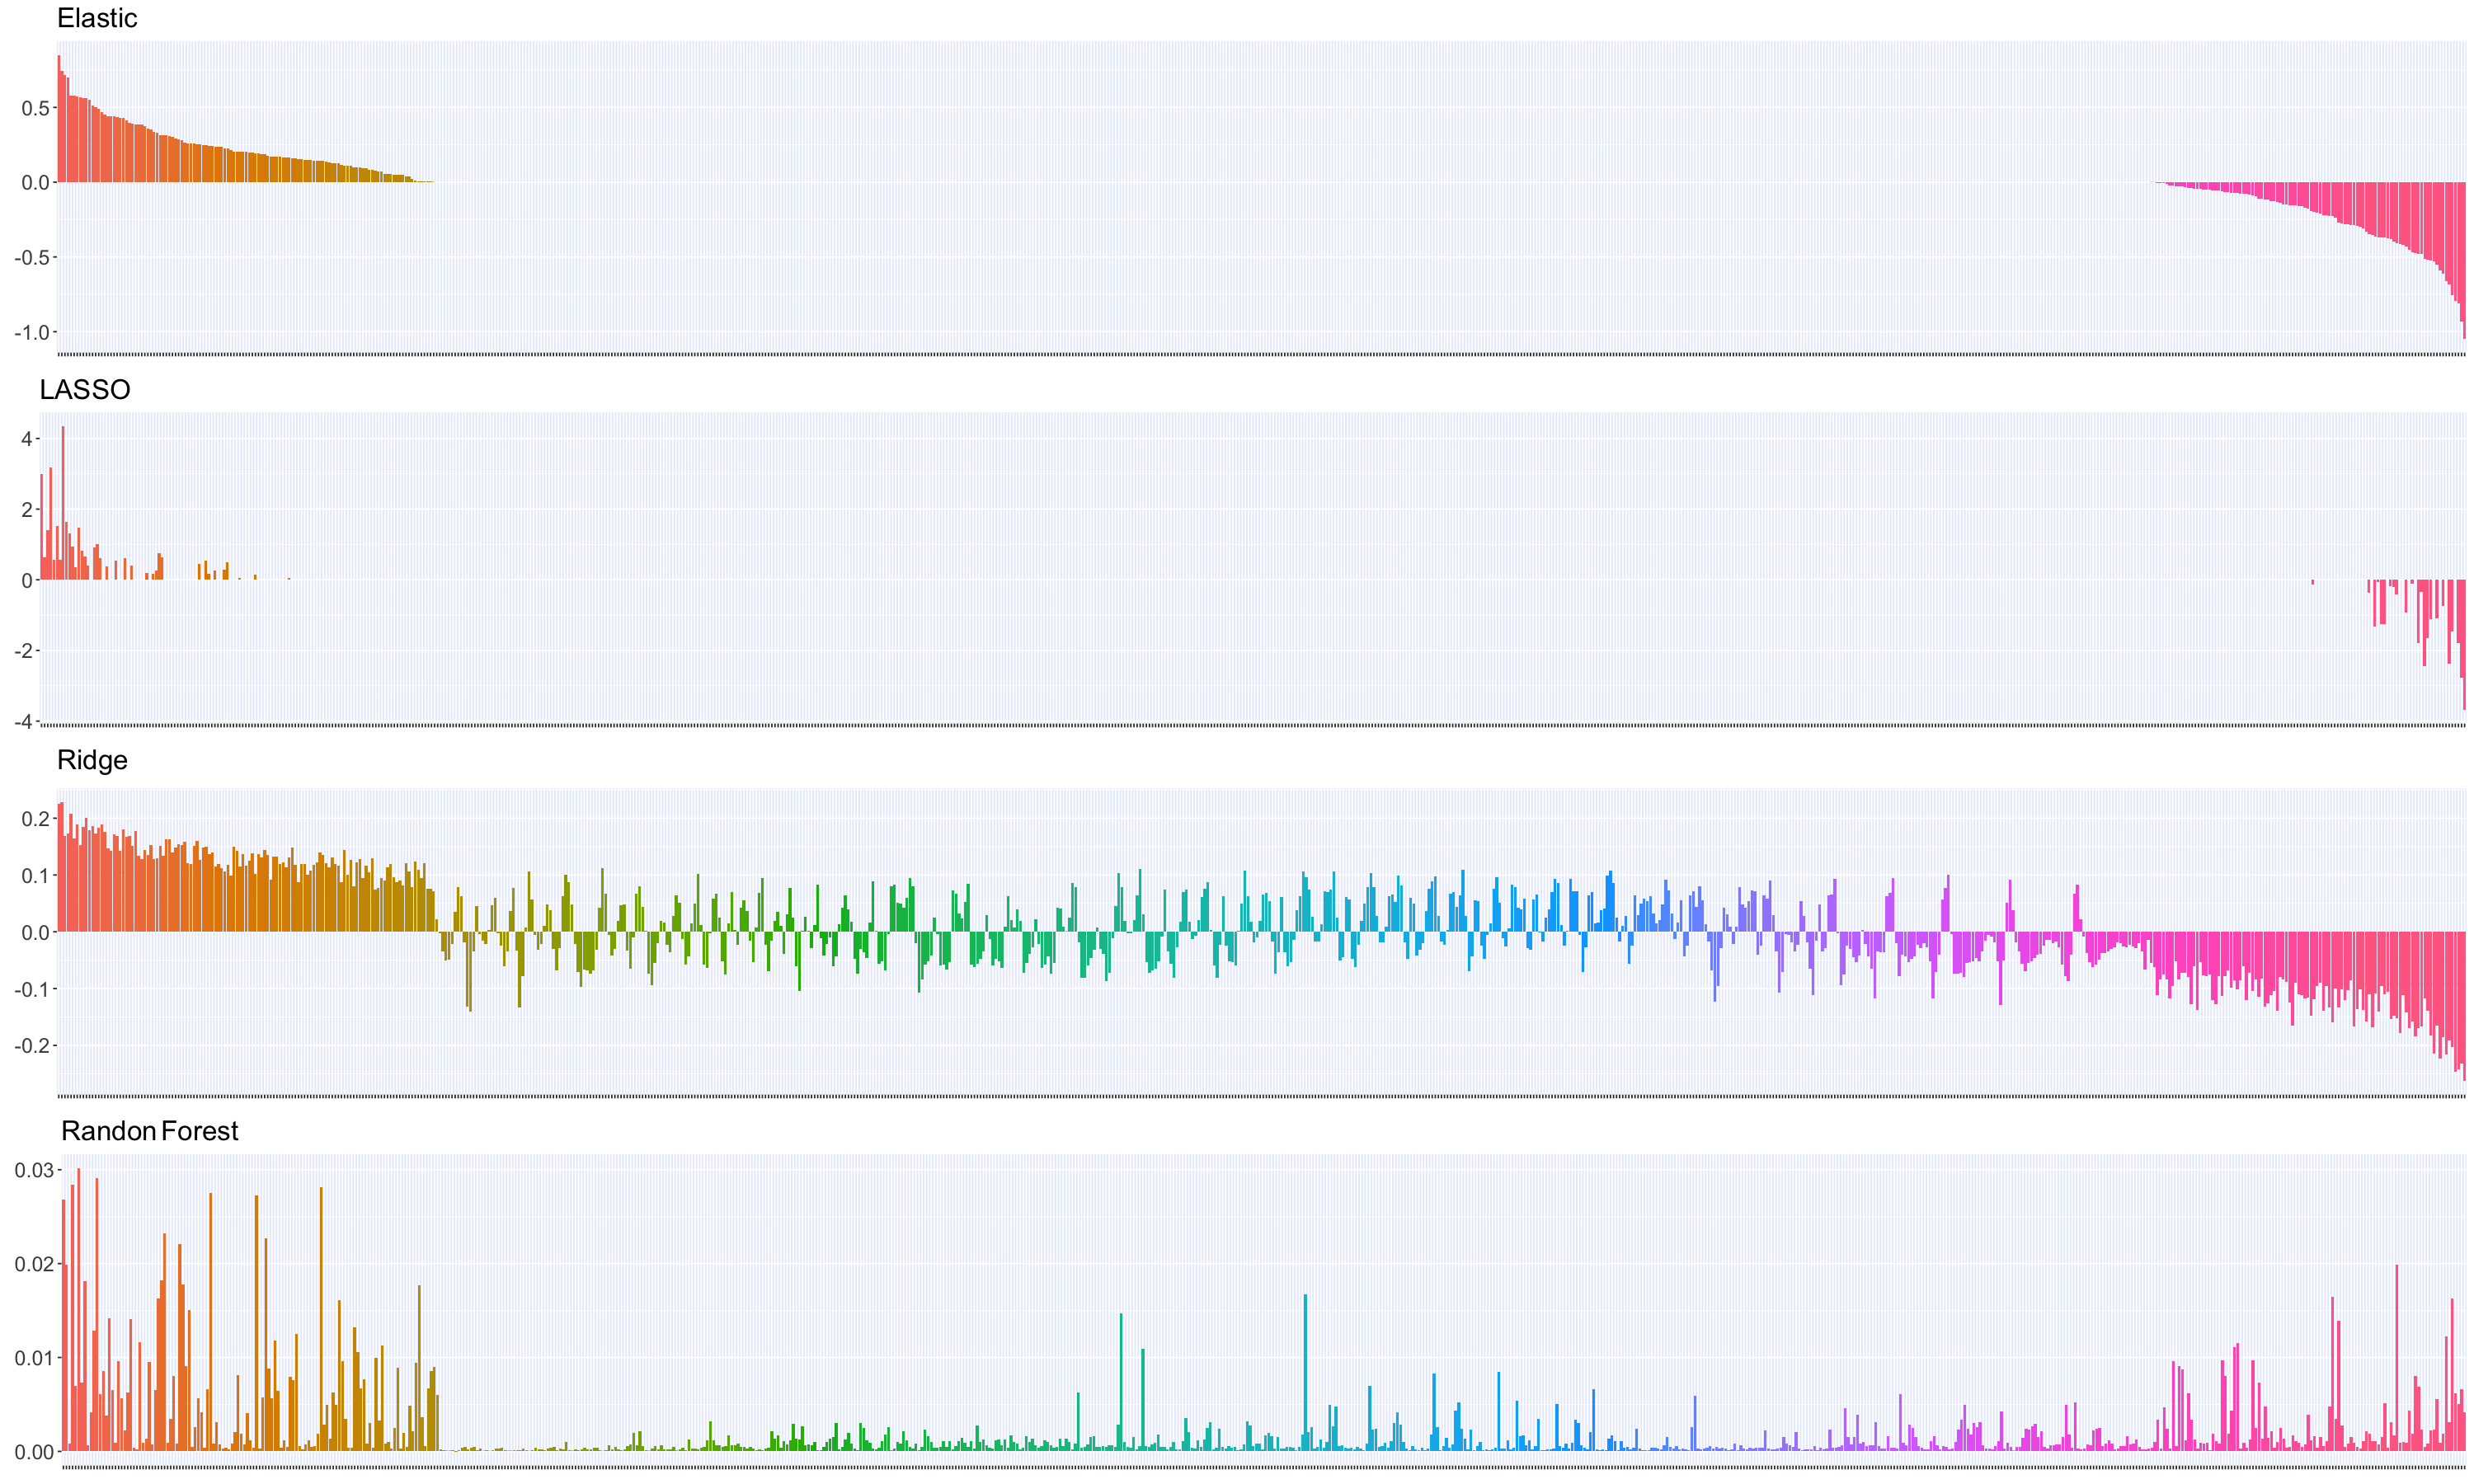

In [40]:
# we need to change the order of factor levels by specifying the order explicitly.
betaS.el$features     =  factor(betaS.el$features, levels = betaS.el$features[order(betaS.el$coefficients, decreasing = TRUE)])
betaS.ls$features     =  factor(betaS.ls$features, levels = betaS.el$features[order(betaS.el$coefficients, decreasing = TRUE)])
betaS.rd$features     =  factor(betaS.rd$features, levels = betaS.el$features[order(betaS.el$coefficients, decreasing = TRUE)])
betaS.rf$features     =  factor(betaS.rf$features, levels = betaS.el$features[order(betaS.el$coefficients, decreasing = TRUE)])

options(repr.plot.width=25, repr.plot.height=15)
el =  ggplot(betaS.el, aes(x=features, y=coefficients, fill=features)) +
  geom_bar(stat = "identity")    +
  labs(x = element_blank()
       , y = element_blank()
       , title = expression(Elastic)
      ) +
  theme(
      panel.background = element_rect(fill="#E8EDFB")
      , axis.text.x = element_blank()
      , axis.text.y = element_text(size=15)
      , plot.title = element_text(size=20, , face = "bold") 
      , legend.position = "none"
  )

ls =  ggplot(betaS.ls, aes(x=features, y=coefficients, fill=features)) +
  geom_bar(stat = "identity")    +
  labs(x = element_blank()
       , y = element_blank()
       , title = expression(LASSO)
      ) +
  theme(
      panel.background = element_rect(fill="#E8EDFB")
      , axis.text.x = element_blank()
      , axis.text.y = element_text(size=15)
      , plot.title = element_text(size=20, , face = "bold")
      , legend.position = "none"
  )

rd =  ggplot(betaS.rd, aes(x=features, y=coefficients, fill=features)) +
  geom_bar(stat = "identity")    +
  labs(
      x = element_blank()
       , y = element_blank()
       , title = expression(Ridge)
      ) +
  theme(
      panel.background = element_rect(fill="#E8EDFB")
      , axis.text.x = element_blank()
      , axis.text.y = element_text(size=15)
      , plot.title = element_text(size=20, , face = "bold")
      , legend.position = "none"
  )

rf =  ggplot(betaS.rf, aes(x=features, y=coefficients, fill=features)) +
  geom_bar(stat = "identity")    +
  labs(
      x = element_blank()
       , y = element_blank()
       , title = expression(Randon~Forest)
      ) +
  theme(
      panel.background = element_rect(fill="#E8EDFB")
      , axis.text.x = element_blank()
      , axis.text.y = element_text(size=15)
      , plot.title = element_text(size=20, face = "bold")
      , legend.position = "none"
  )

grid.arrange(el, ls, rd, rf, nrow = 4)


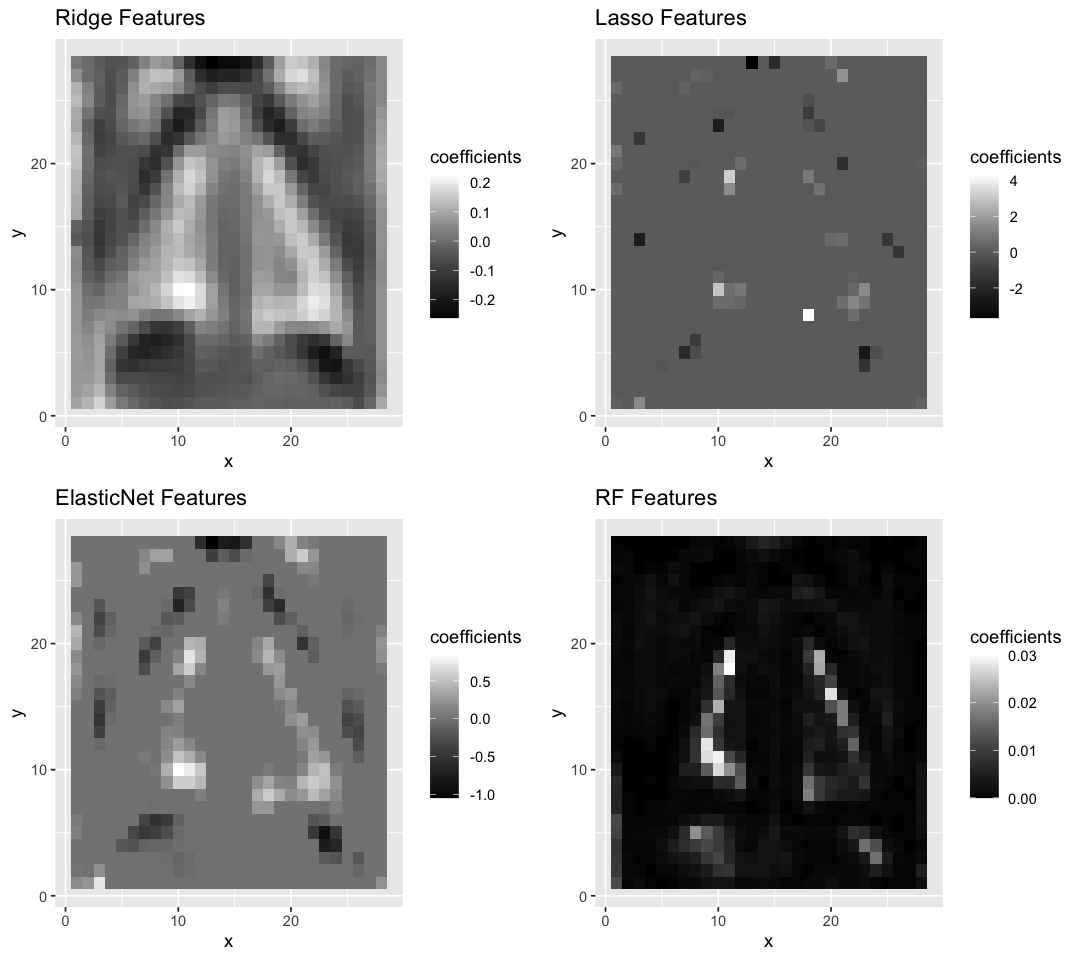

In [25]:
options(repr.plot.width=9, repr.plot.height=8)
g.rd <- betaS.rd %>%
  tidyr::extract(features, "pixel", "(\\d+)", convert = TRUE) %>%  
  mutate(x = pixel %% 28 + 1, y = 28 - pixel %/% 28) %>%
  ggplot(aes(x, y, fill = coefficients)) +  geom_tile() + 
  labs(title = "Ridge Features") + 
  scale_fill_gradient(low="black", high="white") 

g.ls <- betaS.ls %>%
  tidyr::extract(features, "pixel", "(\\d+)", convert = TRUE) %>%  
  mutate(x = pixel %% 28 + 1, y = 28 - pixel %/% 28) %>%
  ggplot(aes(x, y, fill = coefficients)) +  geom_tile() +  
  labs(title = "Lasso Features") +
  scale_fill_gradient(low="black", high="white") 

g.el <- betaS.el %>%
  tidyr::extract(features, "pixel", "(\\d+)", convert = TRUE) %>%  
  mutate(x = pixel %% 28 + 1, y = 28 - pixel %/% 28) %>%
  ggplot(aes(x, y, fill = coefficients)) +  geom_tile() +  
  labs(title = "ElasticNet Features") +
  scale_fill_gradient(low="black", high="white") 

g.rf <- betaS.rf %>%
  tidyr::extract(features, "pixel", "(\\d+)", convert = TRUE) %>%  
  mutate(x = pixel %% 28 + 1, y = 28 - pixel %/% 28) %>%
  ggplot(aes(x, y, fill = coefficients)) +  geom_tile() +  
  labs(title = "RF Features") +
  scale_fill_gradient(low="black", high="white") 

grid.arrange(g.rd, g.ls, g.el, g.rf, nrow = 2, ncol = 2)